# Ising Scattering on the QPU ibm_rensselaer

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from qiskit import(
    QuantumCircuit, 
    ClassicalRegister, 
    QuantumRegister,
    transpile)

In [68]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

# toggle sampler options to turn DD on/off
sampler_options = {
    "dynamical_decoupling": {
        "enable": True,
    },
    "twirling": {
        "enable_gates": True,
    }
}

service = QiskitRuntimeService(name="ising-scattering")
backend = service.backend("ibm_rensselaer")
sampler = Sampler(mode=backend, options=sampler_options)

print(backend)

<IBMBackend('ibm_rensselaer')>


Build multi-site operator:

In [69]:
def build_op(N_s, site, op):
    Op = np.identity(1)
    for s in range(N_s):
        if s == site:
            Op = np.kron(Op, op)
        else:
            Op = np.kron(Op, np.identity(2))
    return Op

In [70]:
N_s = 3

Definitions for standard operators used like Pauli matrices, sigma plus/minus, Hadamard, and number op:

In [71]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
sp = (x + 1j * y) / 2
sm = (x - 1j * y) / 2
had = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
n = np.array([[0, 0], [0, 1]])

X = []
Y = []
Z = []
Sp = []
Sm = []
Had = []
N = []

# This is just building the tensor product
for s in range(N_s):
    X.append(build_op(N_s, s, x))
    Y.append(build_op(N_s, s, y))
    Z.append(build_op(N_s, s, z))
    Sp.append(build_op(N_s, s, sp))
    Sm.append(build_op(N_s, s, sm))
    Had.append(build_op(N_s, s, had))
    N.append(build_op(N_s, s, n))

Jordan-Wigner creation operator:

In [72]:
# JW creation operator
CDAG = []
for s in range(N_s):
    cdag = Sm[s]
    for j in range(s):
        cdag = -Z[j] @ cdag
    CDAG.append(cdag)

A Gaussian wave packet has the form:
\begin{equation}
|\psi_A \rangle = \sum_{j=0}^{N_s -1} e^{-i k_A x_j} e^{-r(x_j, x_A)^2/\sigma^2} \hat{c}^{\dagger}_j |\Omega \rangle
\end{equation}
which we implement below.

In [73]:
vac = np.zeros(2**N_s, dtype=complex)
vac[0] = 1
r = [-1, 0, 1]
kr = 3 * np.pi / 8
kl = -kr
rm_state = np.zeros(2**N_s, dtype=complex)
lm_state = np.zeros(2**N_s, dtype=complex)
for s in range(N_s):
    rm_state += np.exp(1j * kr * s) * np.exp(-r[s]**2/2**2) * CDAG[s] @ vac
    lm_state += np.exp(1j * kl * s) * np.exp(-r[s]**2/2**2) * CDAG[s] @ vac
rm_state /= np.linalg.norm(rm_state)
lm_state /= np.linalg.norm(lm_state)


In [74]:
backend.operations

[Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 qiskit.circuit.controlflow.switch_case.SwitchCaseOp,
 qiskit.circuit.controlflow.if_else.IfElseOp,
 qiskit.circuit.controlflow.for_loop.ForLoopOp,
 Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[])]

Let's construct then plot the approximate Gaussian initial wavepacket using the above.

In [75]:
occs_rm = []
occs_lm = []
for s in range(N_s):
    occs_rm.append(np.inner(rm_state.conjugate(), N[s] @ rm_state))
    occs_lm.append(np.inner(lm_state.conjugate(), N[s] @ lm_state))

/Users/cameron/Documents/Qiskit-software/qiskit-1.0-venv/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/cameron/Documents/Qiskit-software/qiskit-1.0-venv/lib/python3.11/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/cameron/Documents/Qiskit-software/qiskit-1.0-venv/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$\\langle N_s \\rangle$')

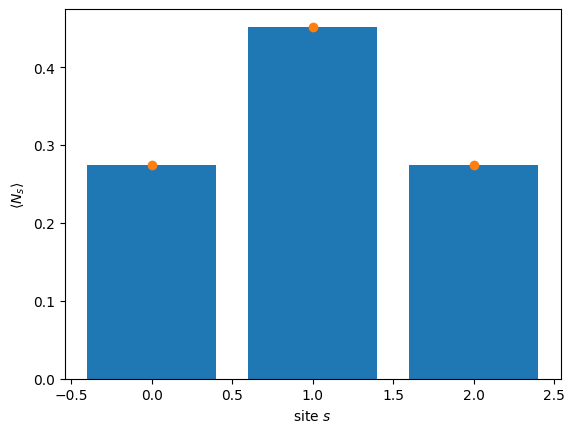

In [76]:
plt.bar(range(N_s), occs_rm, label=r'$+k$')
plt.scatter(range(N_s), occs_lm, label=r'$-k$')
plt.xlabel(r'site $s$')
plt.ylabel(r'$\langle N_s \rangle$')

Now we need to turn the two intial wavepackets into circuits, then combine into one circuit as the initial state. First do the right-moving wavepacket:

State Prep Circuit: 
Circuit depth:  32
{'rz': 32, 'sx': 21, 'ecr': 5, 'reset': 3}


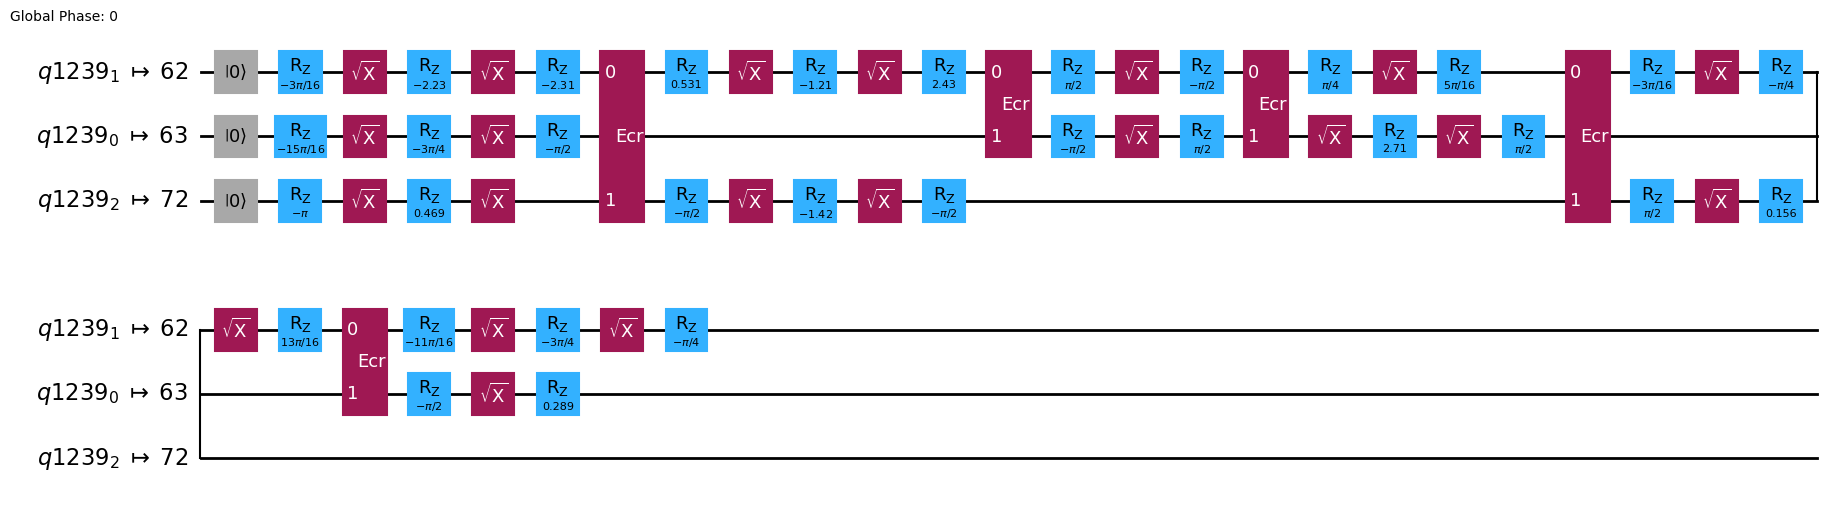

In [77]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
rm_circ = QuantumCircuit(qreg, creg)
#basis_gates = ['u1', 'u2', 'u3', 'cx']
basis_gates = ['reset', 'rz', 'id', 'ecr', 'measure', 'sx', 'x']
# State-Prep
rm_circ.initialize(rm_state, qubits=list(range(N_s)))
# for i in range(5):
#     circ = circ.decompose()
# circ.draw(output='mpl')
rm_circuit = transpile(rm_circ, backend=backend, basis_gates=basis_gates, optimization_level=3)
print("State Prep Circuit: ")
print("Circuit depth: ", rm_circuit.depth())
print(dict(rm_circuit.count_ops()))
rm_circuit.draw(output='mpl', idle_wires=False)

Then do the left-moving one:

State Prep Circuit: 
Circuit depth:  34
{'rz': 29, 'sx': 19, 'ecr': 5, 'reset': 3, 'x': 2}


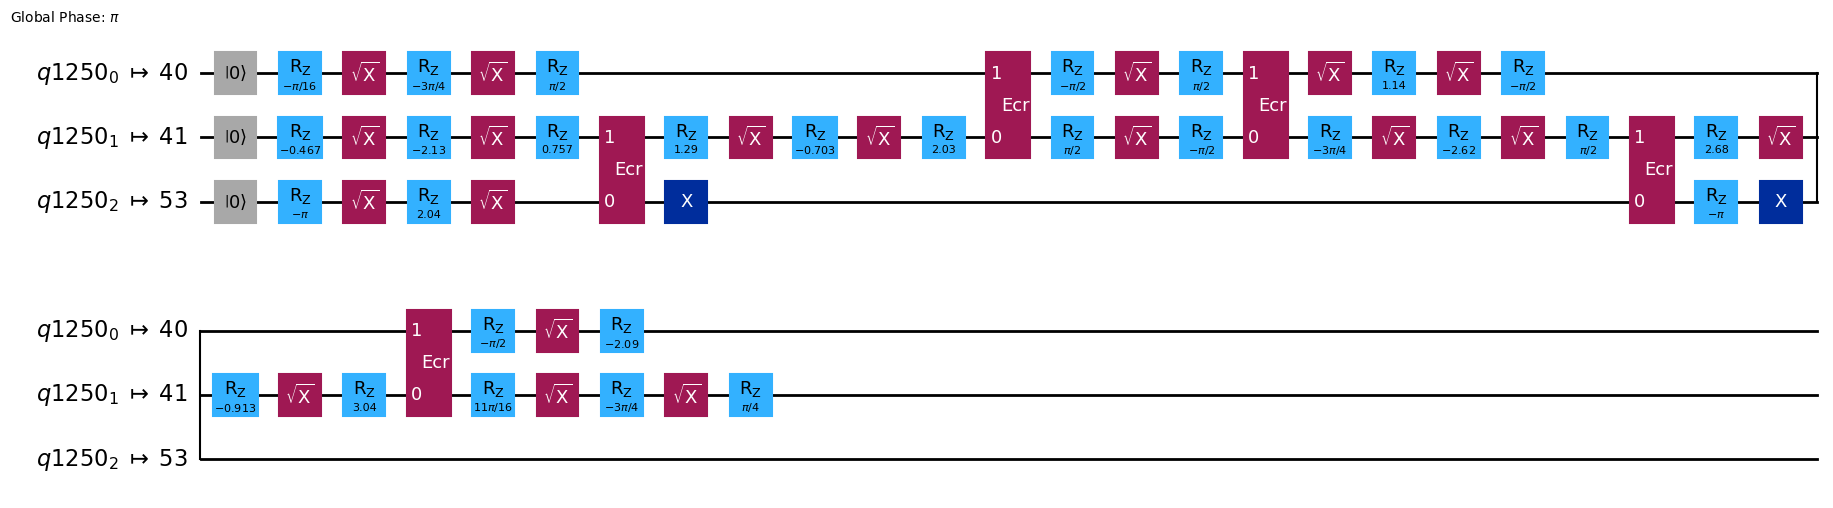

In [78]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
lm_circ = QuantumCircuit(qreg, creg)
#basis_gates = ['u1', 'u2', 'u3', 'cx']
#basis_gates = ['ecr', 'id', 'rz', 'sx', 'x']
basis_gates = ['reset', 'rz', 'id', 'ecr', 'measure', 'sx', 'x']
# State-Prep
lm_circ.initialize(lm_state, qubits=list(range(N_s)))
# for i in range(5):
#     circ = circ.decompose()
# circ.draw(output='mpl')
lm_circuit = transpile(lm_circ, backend, basis_gates=basis_gates, optimization_level=3)
print("State Prep Circuit: ")
print("Circuit depth: ", lm_circuit.depth())
print(dict(lm_circuit.count_ops()))
lm_circuit.draw(output='mpl', idle_wires=False)

Parameters for the time evolution:

In [88]:
N_s = 9
N_t = 10
lam = 0.3
# hL = 0.05
dt = 1
N_t * dt

10

Combine wavepackets into one circuit to create the initial state. Pick an initial_layout using error data from the actual hardware:

State Prep Circuit: 
Circuit depth:  34
{'rz': 51, 'sx': 36, 'ecr': 10, 'reset': 6, 'x': 3}


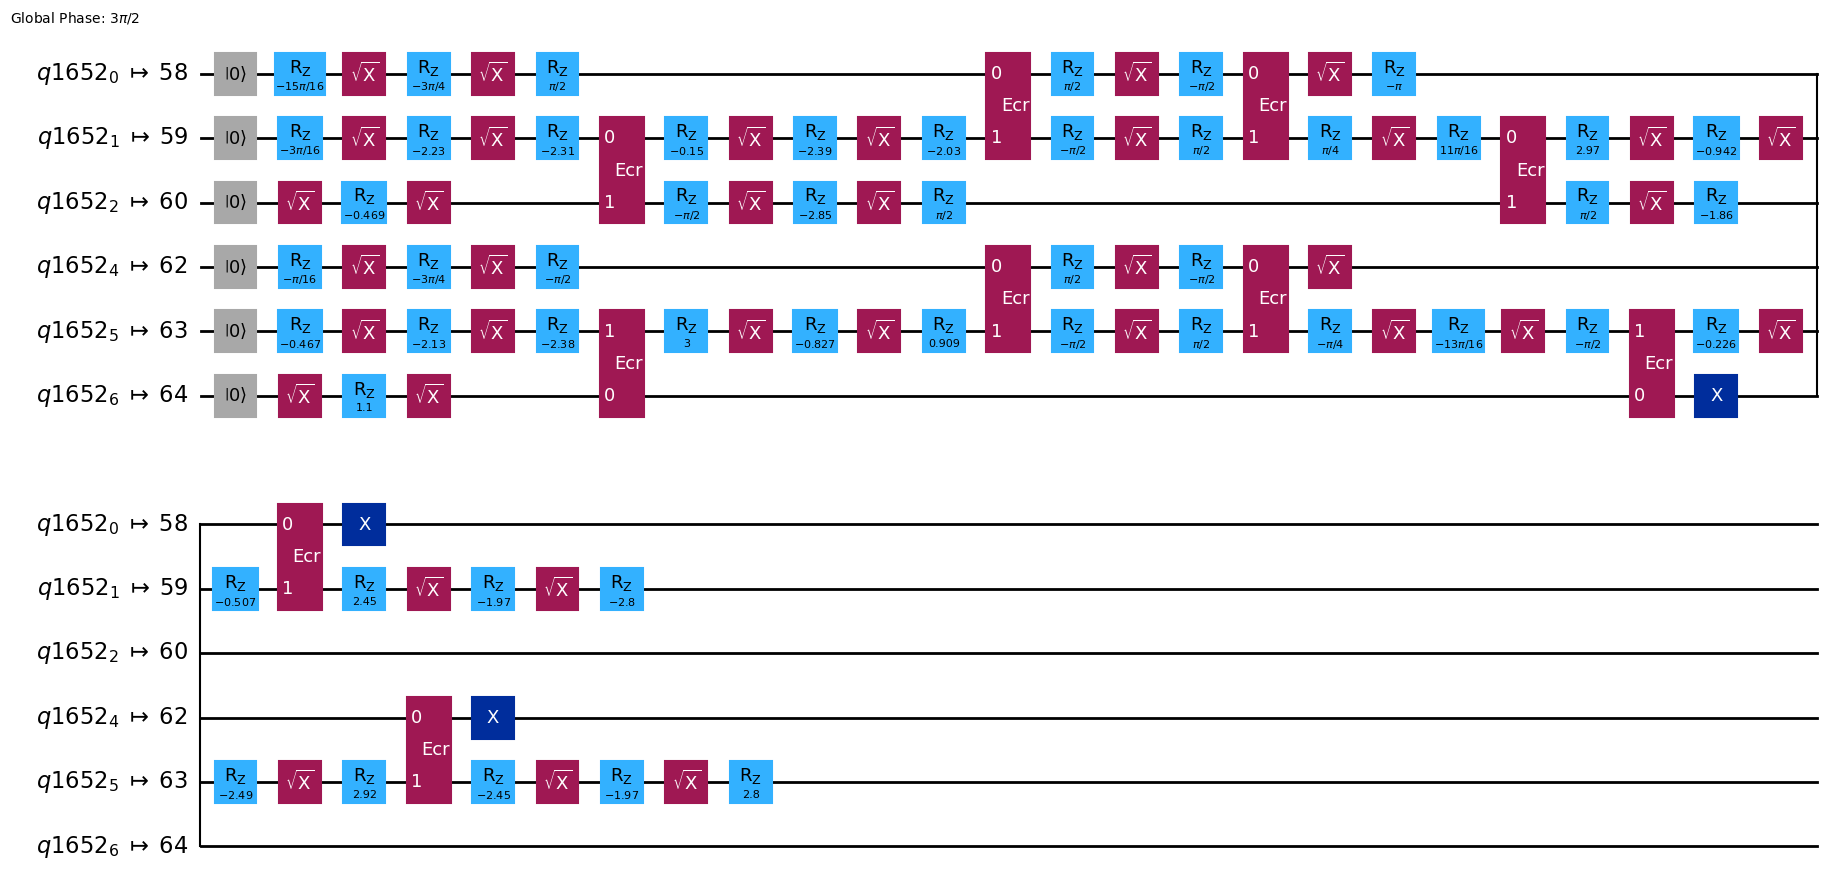

In [89]:
qreg = QuantumRegister(N_s)
creg = ClassicalRegister(N_s)
circ = QuantumCircuit(qreg, creg)

# State-Prep
# circ.initialize(init_state, qubits=list(range(N_s)))
circ = circ.compose(rm_circ, qubits=[0, 1, 2])
circ = circ.compose(lm_circ, qubits=[4, 5, 6])
#circ = circ.compose(rm_circuit, qubits=[0, 1, 2])
#circ = circ.compose(lm_circuit, qubits=[4, 5, 6])

#trans_circuit = transpile(circ.decompose().decompose(), backend, basis_gates=basis_gates, optimization_level=3, initial_layout=[39, 40, 41, 42, 43, 44, 45, 46])
trans_circuit = transpile(circ.decompose().decompose(), backend, basis_gates=basis_gates, optimization_level=3, initial_layout=[58, 59, 60, 61, 62, 63, 64, 65, 66])

print("State Prep Circuit: ")
print("Circuit depth: ", trans_circuit.depth())
print(dict(trans_circuit.count_ops()))

trans_circuit.draw(output='mpl', idle_wires=False)

Finally, do the Trotterization for time evolution:

In [90]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def make_circuit(t_step, num_shots):
    qreg = QuantumRegister(N_s)
    creg = ClassicalRegister(N_s, "creg")
    circ = QuantumCircuit(qreg, creg)

    # State-Prep
    # circ.initialize(init_state, qubits=list(range(N_s)))
    #circ = circ.compose(rm_circuit, qubits=[0, 1, 2])
    #circ = circ.compose(lm_circuit, qubits=[4, 5, 6])
    circ = circ.compose(rm_circ, qubits=[1, 2, 3])
    circ = circ.compose(lm_circ, qubits=[5, 6, 7])
    
    # Trotter Evolution
    for i in range(t_step):
        # Transverse Field
        for j in range(N_s):
            circ.rz(-2 * dt, j)
        # Nearest-neighbor
        for j in range(N_s-1):
            circ.rxx(-2 * lam * dt, j, (j+1) % N_s)
        # # Longitudinal Field
        # for j in range(N_s):
        #     circ.rx(-2 * hL * dt, j)
    
    # Measure
    circ.measure(qreg[::-1], creg)
    #circ.measure_all()
   

    # new_circuit = transpile(circ, backend, 
    #                     basis_gates=['cx', 'id', 'rz', 'x', 'sx'], 
    #                     optimization_level=3)
    
    #job = backend.run(circ, shots = num_shots)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    isa_circuit = pm.run(circ.decompose().decompose())
    job = sampler.run([isa_circuit])

    result = job.result()

    pub_result = result[0]
    #counts = pub_result.data.meas.get_counts()

    #return isa_circuit
    return pub_result
    #return counts

Look at circuit is always good:

In [82]:
#result = make_circuit(0, 10000)

In [83]:
# result.draw('mpl',fold=-1,idle_wires=False)

Now do time evolution by iterating in time:

In [91]:
num_shots = 10000
counts_list = []
for i in range(N_t):
    print(i)
    results = make_circuit(i, num_shots)
    counts_list.append(results)

0
1
2
3
4
5
6
7
8
9


Extract observable from the data:

In [92]:
qc_occ_nums = []
for i in range(N_t):
    expecz = np.zeros(N_s)
    #for key in counts_list[i]:
    for key in counts_list[i].data.creg.get_counts():
        for j in range(N_s):
            if key[j] == '0':
                expecz[j] += counts_list[i].data.creg.get_counts()[key] / num_shots
            else:
                expecz[j] -= counts_list[i].data.creg.get_counts()[key] / num_shots
    qc_occ_nums.append((1 - expecz) / 2)
qc_occ_nums = np.array(qc_occ_nums)

The below is the initial state prepared on the quantum hardware:

Text(0.5, 1.0, '(a) Initial State with DD = True, Twirling = True')

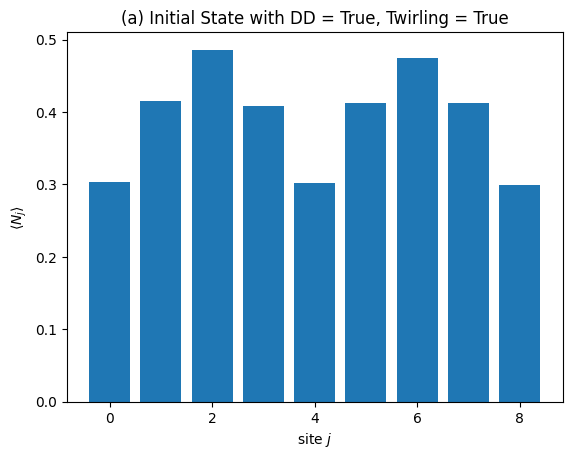

In [93]:
# Qubits 58-66 (added an extra one so a buffer on each end)
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State with DD = True, Twirling = True")

Text(0.5, 1.0, '(a) Initial State with DD = True, Twirling = True')

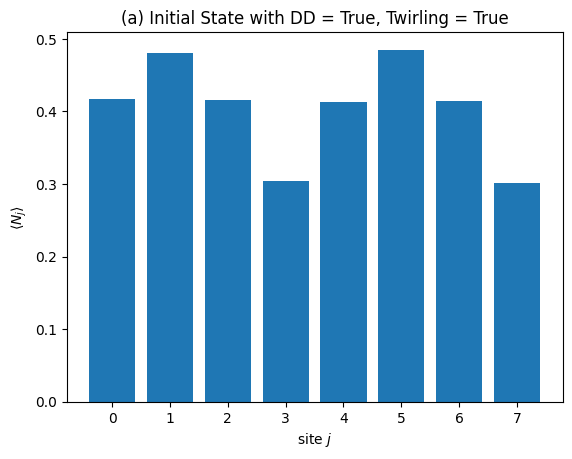

In [86]:
# Qubits 58-65
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State with DD = True, Twirling = True")

Text(0.5, 1.0, '(a) Initial State with DD = True')

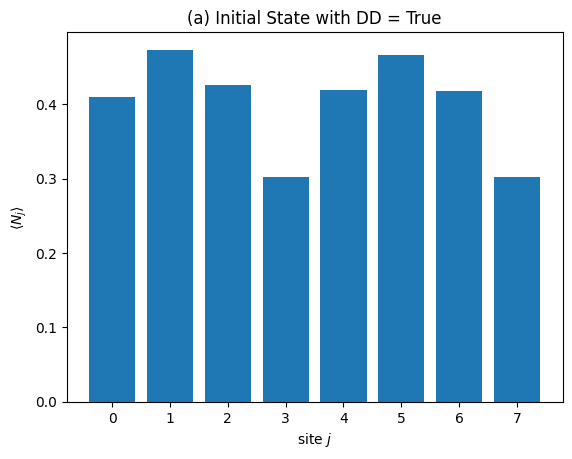

In [41]:
plt.bar(range(N_s), qc_occ_nums[0])
plt.xlabel(r'site $j$')
plt.ylabel(r'$\langle N_j \rangle$')
plt.title("(a) Initial State with DD = True")

Plot the time evolution:

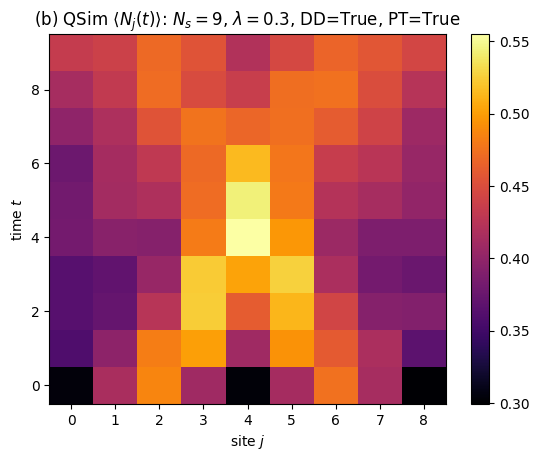

In [94]:
# Qubits 58 - 66 (added an extra so a buffer on the left as well)
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', DD=True, PT=True'
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

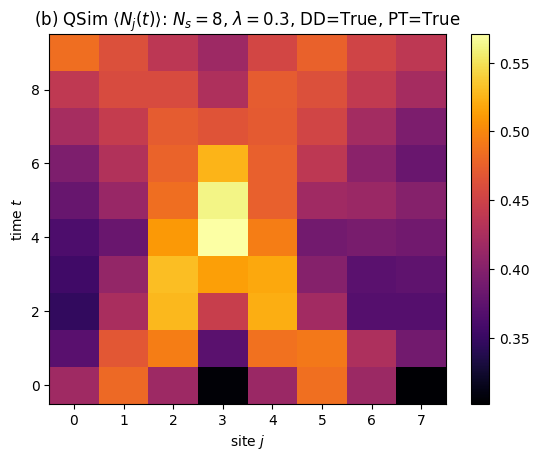

In [87]:
# Qubits 58 - 65
x = np.linspace(0, N_s-1, N_s)
y = np.linspace(0, (N_t - 1) * dt, N_t)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

plt.pcolormesh(X, Y, qc_occ_nums, cmap='inferno')
plt.xlabel(r'site $j$')
plt.ylabel(r'time $t$')
title = r'(b) QSim $\langle N_j (t) \rangle$: $N_s = $' + str(N_s)
title += r', $\lambda = $' + str(lam)
title += r', DD=True, PT=True'
plt.title(title)
plt.colorbar()
# plt.savefig('qc-occ-nums.png')

In [95]:
'''
for i in range(N_t):
    plt.bar(range(N_s), qc_occ_nums[i], label='Exact Trotter', color='gray')
    plt.xlabel('s (site)')
    plt.ylabel(r'$\langle n_s \rangle$')
    plt.legend()
    plt.ylim(0,1.3)
    title = r'$N_s =$' + str(N_s)
    title += r', $\lambda$ = ' + str(lam)
    title += r', $t = $' + str(round(i * dt, 4))
    plt.title(title)
    folder = 'qc-scattering-plots/'
    filename = folder
    filename += 'scatt-timestep' + str(i) + '.png'
    plt.savefig(filename)
    plt.close()
'''

"\nfor i in range(N_t):\n    plt.bar(range(N_s), qc_occ_nums[i], label='Exact Trotter', color='gray')\n    plt.xlabel('s (site)')\n    plt.ylabel(r'$\\langle n_s \rangle$')\n    plt.legend()\n    plt.ylim(0,1.3)\n    title = r'$N_s =$' + str(N_s)\n    title += r', $\\lambda$ = ' + str(lam)\n    title += r', $t = $' + str(round(i * dt, 4))\n    plt.title(title)\n    folder = 'qc-scattering-plots/'\n    filename = folder\n    filename += 'scatt-timestep' + str(i) + '.png'\n    plt.savefig(filename)\n    plt.close()\n"